# Exercises Week 11-12: Graded exercise session (part B)

**Course**: [Life Sciences engineering: genome to function](https://go.epfl.ch/BIO-411) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2024-2025

In [7]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

from scipy.integrate import odeint
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from adjustText import adjust_text
import scipy
from scipy.stats import beta
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import seaborn as sns



**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell.**

### Exercise 1: Simulation of circadian gene regulation

In this exercise, we revisit and extend the concepts from Week 9, focusing on the transcription and splicing of a pre-mRNA to produce mRNA. We describe this process using a two-dimensional Ordinary Differential Equation (ODE), similar to our previous approach but with a key difference: we now incorporate **time-dependent** transcription and degradation rates to model circadian rhythms.

The system is defined by the following ODEs:

\begin{array}{ll}
\frac{dP}{dt} = s(t) - \rho P \\  
\\
\frac{dM}{dt} = \rho P - k(t) M \\
\end{array}

where  $P$ and $M$ represent the concentrations of pre-mRNA and mRNA, respectively. We will consider time-dependent (circadian) transcription and degradation rates. The frequency is defined by $\omega=\frac{2\pi}{T}$ with $T=24h$.  

$s(t)$ is the transcription rate, which is now taken either as constant $s(t)=s_{0}$ or as a rhythmic function of time:  

\begin{equation*}
s(t) = s_0(1 + \epsilon_s \cos(\omega t)) 
\end{equation*}  
with relative amplitude $0\leq \epsilon_s\leq 1$. Note that the peak of $s(t)$ is at $t=0$.  
 
Similarly, we will consider the degradation rate $k(t)$ either as constant $k(t)= k_0$ or a rhythmic function of time:  
\begin{equation*}
k(t)=k_0(1 + \epsilon_k \cos(\omega (t-t_k))
\end{equation*}  
with $0\leq\epsilon_k\leq 1$, and the maximum degradation rate at $t=t_k$.

$\rho$ represents the constant splicing rate of pre-mRNA $P$ into mRNA $M$.

### Question 1
1. Adapt the code from Week 9 exercises to simulate this system with rhythmic transcription and degradation rates. Modify the interactive widget such that you can vary the new parameters and plot $P(t)$ and $M(t)$.  

2. Keep the degradation rate constant (set $\epsilon_k$=0) and vary $k_0$ and $\epsilon_s$.
    * How does the phase delay between $M(t)$ and $P(t)$ changes with different values of $k_0$?
    * How does the amplitude (use the ratio between max and min) of $M(t)$ changes with different values of $k_0$? 
    
    Make sure you span a relevant range for $k_0^{-1}$ ( *i.e.* from 10 minutes to several hours).  

3. Now introduce rhythmic degradation by varying $\epsilon_k$. 
    * Show that you can obtain a rhyhtmic mRNA accumulation when the synthesis is constant ($\epsilon_s=0$). 
    


---

## ANSWER


### 1. 



1. **Update the ODE Function**  
   - Include rhythmic functions for the transcription rate `s(t)` and the degradation rate `k(t)` using cosine functions to model circadian rhythms.

2. **Update the Simulation Function**  
   - Incorporate the following new parameters:  
     - `s₀`: baseline transcription rate.  
     - `ϵₛ`: relative amplitude of transcription.  
     - `k₀`: baseline degradation rate.  
     - `ϵₖ`: relative amplitude of degradation.  
     - `tₖ`: maximum degradation rate.  
     - `ρ`: constant splicing rate.  

3. **Adapt the Interactive Widget**  
   - Enable variation of the new parameters (`ϵₛ`, `ϵₖ`, `kt`...).

4. **Solve and Plot the ODEs**  
   - Solve the ODEs with given initial conditions.  
   - Plot the concentrations of `P(t)` and `M(t)` over multiple circadian cycles (48 hours).

In [13]:
def production_decay_ode(y, t, s0, eps_s, omega, rho, k0, eps_k, tk):
    """
    Parameters:
    y (list): A list containing the concentrations of pre-mRNA (P) and mRNA (M).
    t (float): Time variable.
    s0 (float): Baseline transcription rate.
    eps_s (float): Amplitude of the oscillation in the transcription rate.
    omega (float): Angular frequency of the oscillation.
    rho (float): Splicing rate.
    k0 (float): Baseline mRNA degradation rate.
    eps_k (float): Amplitude of the oscillation in the mRNA degradation rate.
    tk (float): maximum degradation rate.

    Returns:
    list: A list containing the derivatives [dPdt, dMdt], where dPdt is the rate of change of pre-mRNA concentration and dMdt is the rate of change of mRNA concentration.
    """
    P, M = y
    st = s0 * (1 + eps_s * np.cos(omega * t))
    kt = k0 * (1 + eps_k * np.cos(omega * (t - tk)))
    dPdt = st - rho * P
    dMdt = rho * P - kt * M
    return [dPdt, dMdt]


def simulation(ode_function, parameters, initial_conditions=None, time=None):
    """
    Simulate the ODEs for the production and decay of pre-mRNA and mRNA.
    parameters: parameters for the ODEs
    initial_conditions: initial conditions for the ODEs
    time: time intervals for the simulation
    """
    s0 = parameters['s0']
    eps_s = parameters['eps_s']
    omega = parameters['omega']
    rho = parameters['rho']
    k0 = parameters['k0']
    eps_k = parameters['eps_k']
    tk = parameters['tk']

    # resolve the ODEs
    results = odeint(ode_function, initial_conditions, time, args=(s0, eps_s, omega, rho, k0, eps_k, tk))

    # plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(time, results[:, 0], label='P(t)', linewidth=2)
    plt.plot(time, results[:, 1], label='M(t)', linewidth=2)
    plt.xlabel("Temps [hours]")
    plt.ylabel("Concentration")
    plt.title('Simulation of pre-mRNA and mRNA Production-Decay Dynamics')
    plt.legend()
    plt.grid(True)
    plt.show()


def animate(initial_conditions, time, s0=1, eps_s=0, k0=0.1, eps_k=0, tk=0, rho=0.1):
    T = 24  # Periode of the oscillation
    omega = 2 * np.pi / T  # angular frequency

    parameters = {
        's0': s0,
        'eps_s': eps_s,
        'omega': omega,
        'rho': rho,
        'k0': k0,
        'eps_k': eps_k,
        'tk': tk
    }

    simulation(production_decay_ode, parameters, initial_conditions, time)



In [ ]:

# Define initial conditions and time intervals for the simulation
initial_conditions = [0, 0]  # [P, M]
time = np.linspace(0, 24*5, 1000)  # 5 days 

# Création du widget interactif
interact(
    animate,
    initial_conditions=fixed(initial_conditions),
    time=fixed(time),
    s0=(0.0, 5.0, 0.1),
    eps_s=(0.0, 1.0, 0.1),
    k0=(0.01, 4, 0.05),
    eps_k=(0.0, 1.0, 0.1),
    tk=(0.0, 24.0, 1.0),
    rho=(0.01, 1.0, 0.01)
)


interactive(children=(FloatSlider(value=1.0, description='s0', max=5.0), FloatSlider(value=0.0, description='e…

<function __main__.animate(initial_conditions, time, s0=1, eps_s=0, k0=0.1, eps_k=0, tk=0, rho=0.1)>

### 2. 


In [ ]:
# Simulation parameters
T = 24  # Circadian period in hours
omega = 2 * np.pi / T
s0 = 1.0
eps_s = 0.9  # Relative amplitude of transcription
rho = 0.1
eps_k = 0  # Relative amplitude of degradation (set to 0)
tk = 0  # Time of maximum degradation (set to 0)
time = np.linspace(0, 24*4, 1000)  # Simulation over 3 days

# Study for different values of k0
k0_values = np.linspace(0.1, 4.15, 4)  # Corresponds to varied half-lives
results = []

for k0 in k0_values:
    y0 = [0, 0]  # Initial conditions [P, M]
    sol = odeint(production_decay_ode, y0, time, args=(s0, eps_s, omega, rho, k0, eps_k, tk))
    results.append((k0, sol))

# Visualization
for k0, sol in results:
    plt.figure(figsize=(5, 3))
    plt.plot(time, sol[:, 0], label='P(t)', linewidth=2)  # Pre-mRNA
    plt.plot(time, sol[:, 1], label='M(t)', linewidth=2)  # mRNA
    plt.title(f"Simulation with k0 = {k0}")
    plt.xlabel("Time [h]")
    plt.ylabel("Concentration")
    plt.legend()
    plt.grid()
    plt.show()
    P = sol[:, 0]
    M = sol[:, 1]

    # Consider only values of time > 40 to avoid transient dynamics
    valid_indices = time > 40
    P = P[valid_indices]
    M = M[valid_indices]
    valid_time = time[valid_indices]

    # Calculate the vertical offset of M(t)
    M_offset = np.mean(M)

    # Remove the offset from M(t) to calculate the true oscillation amplitude
    M_centered = M - M_offset

    # Calculate the amplitude as half the difference between the maximum and minimum values of the centered M
    M_amplitude = (np.max(M_centered) - np.min(M_centered)) / 2

    print(f"k0 = {k0:.2f} | Amplitude of M: {M_amplitude:.2f}")

    # Find the peaks of P(t) and M(t)
    P_peaks = (np.diff(np.sign(np.diff(P))) < 0).nonzero()[0] + 1
    M_peaks = (np.diff(np.sign(np.diff(M))) < 0).nonzero()[0] + 1

    if len(P_peaks) > 0 and len(M_peaks) > 0:
        # Calculate the average phase delay
        phase_delays = []
        for P_peak in P_peaks:
            closest_M_peak = M_peaks[np.argmin(np.abs(M_peaks - P_peak))]
            phase_delay = valid_time[closest_M_peak] - valid_time[P_peak]
            phase_delays.append(phase_delay)
        
        average_phase_delay = np.mean(phase_delays)
        print(f"k0 = {k0:.2f} | Phase Delay: {average_phase_delay:.2f} hours")
    else:
        print(f"k0 = {k0:.2f} | Phase Delay: N/A")



#### **Key Concepts**

1. **Phase Shift between M(t) and P(t)**:
   - The phase shift corresponds to the time delay between the peaks of P(t) (pre-mRNA) and M(t) (mRNA). This shift is influenced by the conversion rate of P into M (denoted as rho) and the degradation rate of M (k0).

2. **Amplitude of M(t)**:
   - The amplitude is the ratio between the maximum and minimum values of M(t). A rapid degradation rate (k0) decreases the amplitude of M(t).

#### **Constant k0 (epsilon_k = 0)**

The degradation rate k0 is related to the half-life T_1/2 by the formula:

T_1/2 = ln(2) / k0

**Examples**:

- For a half-life T_1/2 of 10 minutes (which is approximately 0.1667 hours):

  k0 is approximately 4.15 per hour.

- For a half-life T_1/2 of 6 hours:

  k0 is approximately 0.1155 per hour.

**Realistic range for simulations**:

k0 is typically between 0.1 and 4.5 per hour.


#### **Expected Results**

The parameter epsilon_s amplifies the oscillations of P(t), which in turn affects the oscillations of M(t). Without oscillations (epsilon_s = 0), there is neither phase shift nor amplitude in M(t).

##### Phase Shift between M(t) and P(t)

1. **Effect of k0**:

   - **High k0 (rapid degradation)**:
     - M(t) depends mainly on the immediate flux of P(t) rather than its accumulation.
     - The phase shift is reduced because M(t) quickly follows changes in P(t).

   - **Low k0 (slow degradation)**:
     - M(t) accumulates past contributions of P(t), leading to a greater time delay.
     - The phase shift increases as M(t) responds more slowly to changes in P(t).

2. **Conclusion**:

   - When k0 is low: M(t) exhibits a significant phase shift relative to P(t).
   - When k0 is high: M(t) is almost in phase with P(t).

##### Amplitude of M(t)

1. **Effect of k0**:

   - **Low k0 (slow degradation)**:
     - M(t) accumulates more, reaching higher maximum values.
     - The amplitude of M(t) increases due to the slower degradation.

   - **High k0 (rapid degradation)**:
     - M(t) oscillates at lower levels since it is quickly degraded after production.
     - The average concentration and amplitude of M(t) decrease.

2. **Conclusion**:

   - When k0 is low: High amplitude in M(t).
   - When k0 is high: Low amplitude in M(t).



#### 3. 

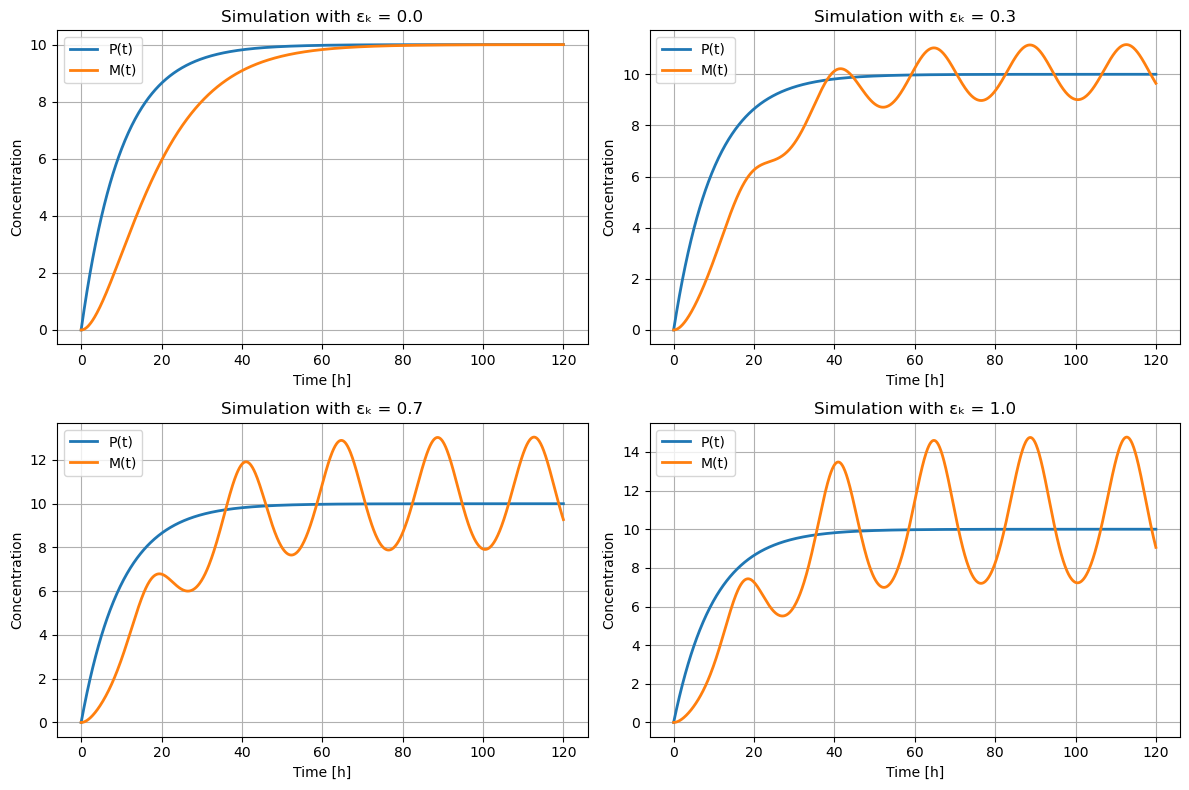

In [24]:
# Example with eps_s = 0 and varying eps_k
eps_k_values = [0.0, 0.3, 0.7, 1.0]  # Relative amplitude of degradation
eps_s = 0.0  # Constant transcription rate

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.flatten()

for i, eps_k in enumerate(eps_k_values):
    parameters = {
        's0': 1,
        'eps_s': eps_s,
        'omega': 2 * np.pi / 24,
        'rho': 0.1,
        'k0': 0.1,
        'eps_k': eps_k,
        'tk': 0
    }
    results = odeint(production_decay_ode, initial_conditions, time, args=(
        parameters['s0'], parameters['eps_s'], parameters['omega'], parameters['rho'],
        parameters['k0'], parameters['eps_k'], parameters['tk']
    ))
    ax[i].plot(time, results[:, 0], label='P(t)', linewidth=2)
    ax[i].plot(time, results[:, 1], label='M(t)', linewidth=2)
    ax[i].set_title(f"Simulation with εₖ = {eps_k}")
    ax[i].set_xlabel("Time [h]")
    ax[i].set_ylabel("Concentration")
    ax[i].legend()
    ax[i].grid(True)

plt.tight_layout()
plt.show()


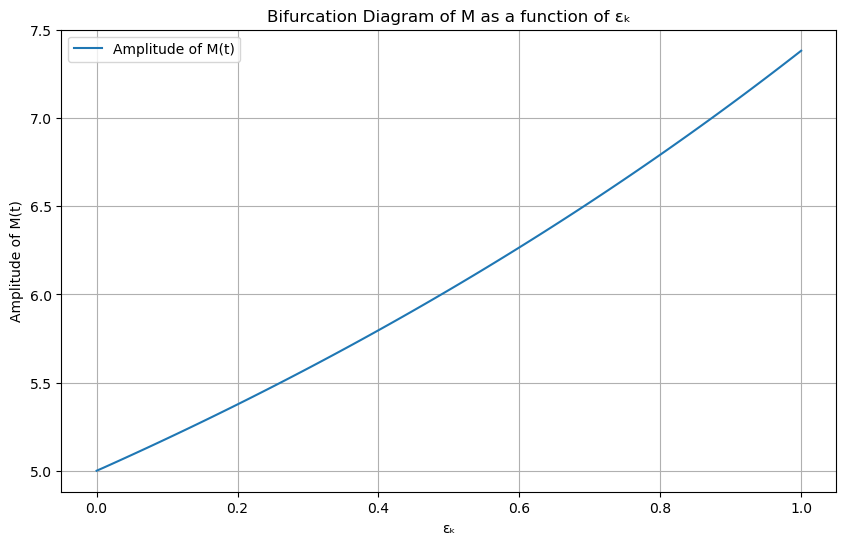

In [30]:
# Bifurcation diagram of M as a function of epsilon_k
eps_k_values = np.linspace(0, 1, 100)  # Range of epsilon_k values
M_amplitudes = []

for eps_k in eps_k_values:
    parameters['eps_k'] = eps_k
    results = odeint(production_decay_ode, initial_conditions, time, args=(
        parameters['s0'], parameters['eps_s'], parameters['omega'], parameters['rho'],
        parameters['k0'], parameters['eps_k'], parameters['tk']
    ))
    M = results[:, 1]
    M_centered = M - np.mean(M)
    M_amplitude = (np.max(M_centered) - np.min(M_centered)) / 2
    M_amplitudes.append(M_amplitude)

plt.figure(figsize=(10, 6))
plt.plot(eps_k_values, M_amplitudes, label='Amplitude of M(t)')
plt.xlabel('εₖ')
plt.ylabel('Amplitude of M(t)')
plt.title('Bifurcation Diagram of M as a function of εₖ')
plt.grid(True)
plt.legend()
plt.show()


By setting eps_s = 0 (constant transcription rate) and varying eps_k, we can observe the following:

- **eps_k = 0**:  
  M(t) remains constant because both the degradation and synthesis rates are constant.

- **eps_k > 0**:  
  Even with a constant synthesis rate, the rhythmic degradation of mRNA induces oscillations in M(t).

  **Amplitude of oscillations**:  
  The amplitude depends on the value of eps_k. The larger eps_k, the more pronounced the oscillations of M(t).


# Part 2

### Exercise 2: Circadian (post-)transcriptional regulation of gene expression in mouse liver and muscle

In this exercise, we will analyze RNA-seq data from mouse liver and muscle under a night-restricted feeding regimen and in the presence of a 12-hour light-dark cycle. The samples were harvested every 2 hours around the clock, with higher resolution around the fasting-feeding transition (ZT12), in two replicates. Similar to the Week 9 exercises on RNA-seq data, gene expression was quantified at the intron (i.e., unspliced) and exon (i.e., spliced) levels. Note that the data are $log_2$-transformed and normalized by transcript length (RPKM, Reads Per Kilobase per Million mapped reads).

### Function definition

In [3]:
def run_PCA(data, n_components=5, color_by='replicate', symbol_by='time', scale_data=True):
    
    """
    Runs PCA on the provided data and generates a scatter plot of pairs of principal components.
    It also returns a DataFrame containing the PCA loadings.

    Parameters:
    data: The gene expression data to analyze.
    n_components: The number of principal components to calculate.
    color_by: The metadata category to color the data points by.
    symbol_by: The metadata category to symbolize the data points by.
    scale_data: Whether to scale the data before PCA.

    Returns:
    pd.DataFrame: A DataFrame containing the PCA loadings.
    """

    data_tmp = data.copy()
    
    # Scale and/or log-transform the data if specified
    if scale_data:
        data = scale(data)
    else:
        data = data

        
    # Fit the PCA model
    pca = PCA(n_components=n_components)
    pca.fit(data.T)

    # Transform the data
    pca_transformed = pca.transform(data.T)

    # Create a DataFrame for the PCA results
    labels = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(pca_transformed, columns=labels)
    if color_by=='time':
        pca_df[color_by] = pd.to_numeric(data_tmp.columns.get_level_values(color_by))
        palette='twilight'
    else:
        pca_df[color_by] = data_tmp.columns.get_level_values(color_by)
        palette='Set1'
    pca_df[color_by] = data_tmp.columns.get_level_values(color_by)
    pca_df[symbol_by] = data_tmp.columns.get_level_values(symbol_by)

    # Plotting each pair of consecutive principal components
    fig, axes = plt.subplots(1, n_components -1, figsize=(30, 5))
    for i in range(n_components-1):
        sns.scatterplot(ax=axes[i], data=pca_df, x=f'PC{i+1}', y=f'PC{i+2}', 
        hue=color_by, style=symbol_by, s=200, palette=palette)

        axes[i].set_xlabel(f'PC{i+1} ({pca.explained_variance_ratio_[i]*100:.2f}%)')
        axes[i].set_ylabel(f'PC{i+2} ({pca.explained_variance_ratio_[i+1]*100:.2f}%)')
        axes[i].set_box_aspect(1) 
        # remove legend if it's not the first plot
        if i == 0:
        # Move legend outside for the first plot
            axes[i].legend(loc='upper center', bbox_to_anchor=(1.3, 1), ncol=2, title=color_by)
        else:
        # Remove legend for all other plots
            axes[i].get_legend().remove()
    fig.suptitle(f'PCA of Gene Expression Data (color={color_by}, symbol={symbol_by})', fontsize=16)
    plt.tight_layout()
    
    # Return the PCA loadings
    df_pca = pd.DataFrame(pca.components_, columns=data_tmp.index, index=labels)

    return df_pca

def subselect(data, feature = None, replicate = None, time = None, condition = None):

    """
    Subselects samples from the full dataset based on the specified features, conditions, 
    replicates, and time points.

    Parameters:
    data: The full gene expression dataset.
    feature: The features to filter by (e.g., ['intron', 'exon']).
    replicate: The replicates to include.
    time: The time points to include.
    condition: The conditions to include (e.g, ['muscle', 'liver']).

    Returns:
    pd.DataFrame: The filtered dataset.
    """
    
    # Create boolean masks for each filtering criterion
    if feature is None:
        feature = data.columns.get_level_values('feature').unique()
    if replicate is None:
        replicate = data.columns.get_level_values('replicate').unique()
    if time is None:
        time = data.columns.get_level_values('time').unique()
    if condition is None:
        condition = data.columns.get_level_values('condition').unique()

    feature_mask  = data.columns.get_level_values('feature').isin(feature)
    condition_mask  = data.columns.get_level_values('condition').isin(condition)
    replicate_mask  = data.columns.get_level_values('replicate').isin(replicate)
    time_mask = data.columns.get_level_values('time').isin(time)

    # Use the masks to filter the data
    filtered_data = data.iloc[:, feature_mask & condition_mask & replicate_mask & time_mask]
    
    return filtered_data

def harm_reg(x, t, period):
    """
    Fit a harmonic regression model to a time series. Perform likelihood ratio test between the full and null model. Get p-value from the test.
    
    Parameters:
    x (array): Time series data
    t (array): Time points
    period (float): Period of the harmonic function (e.g., 24 for daily rhythms)

    Returns:
    tuple: Mean (mu), peak-to-through amplitude (amp), phase (phase), and p-value (p_val)

    """

    n = len(x)
    
    # Fit the null model (intercept only)
    X0 = np.ones((n, 1))  # Design matrix for the null model
    fit0 = sm.OLS(x, X0).fit()
    
    c = np.cos(2 * np.pi * t / period)
    s = np.sin(2 * np.pi * t / period)
    
    # Design matrix for the full model
    X1 = np.column_stack((np.ones(n), c, s))
    fit1 = sm.OLS(x, X1).fit()
    
    # Coefficients
    mu = fit1.params[0]
    a = fit1.params[1]
    b = fit1.params[2]
    
    # Likelihood ratio test
    lr_stat = 2 * (fit1.llf - fit0.llf)
    p_val = scipy.stats.chi2.sf(lr_stat, 2)
    
    # Amplitude and phase
    amp = 2 * np.sqrt(a**2 + b**2)
    phase = np.arctan2(b, a) % (2 * np.pi)
    phase = period * phase / (2 * np.pi)

    
    return mu, amp, phase, p_val

def fit_harmo(data, time, period):
    """
    Applies the harm_reg function to all genes for a given normalized gene expression dataset.

    Parameters:
    data (pd.DataFrame): Normalized gene expression dataset with genes as rows.
    time (array): Time points for the dataset.
    period (float): Period of the harmonic function (e.g., 24 for daily rhythms).

    Returns:
    pd.DataFrame: A DataFrame containing the amplitude, phase, p-value, qvalue and mu for each gene.
    """
    results = data.apply(lambda x: harm_reg(x.values, time, period), axis=1)
    results_df = pd.DataFrame(results.tolist(), index=data.index, columns=['mu', 'amp', 'phase', 'p_val'])
    results_df['p_val'] = results_df['p_val'].fillna(1)
    results_df['q_val'] = multipletests(results_df['p_val'], method='fdr_bh')[1]

    return results_df


# Plotting function for side-by-side liver and muscle plots
def plot_gene_expression(dat_melted, gene_name):
    """
    Plots the expression of a gene in liver and muscle over time.

    Parameters:
    dat_melted (pd.DataFrame): The melted gene expression dataset.
    gene_name (str): The gene to plot.

    Returns:
    None
    """

    # Filter the melted DataFrame for the gene of interest
    data = dat_melted[dat_melted['gene.symb'] == gene_name]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # Create 1 row, 2 columns
    
    # Plot Liver
    sns.scatterplot(
        data=data[data['condition'] == 'liver'],  # Filter directly for liver
        x='time', y='expression', hue='feature', style='feature',
        alpha=0.6, legend='full', ax=axes[0]
    )
    sns.lineplot(
        data=data[data['condition'] == 'liver'],  # Filter directly for liver
        x='time', y='expression', hue='feature', estimator='mean',
        errorbar=None, legend=False, ax=axes[0]
    )
    axes[0].set_title(f"{gene_name} Expression in Liver")
    axes[0].set_xlabel("Time (hours)")
    axes[0].set_ylabel("Expression Level")
    axes[0].grid(alpha=0.3)
    axes[0].set_box_aspect(1)  # Ensure square aspect ratio

    # Plot Muscle
    sns.scatterplot(
        data=data[data['condition'] == 'muscle'],  
        x='time', y='expression', hue='feature', style='feature',
        alpha=0.6, legend='full', ax=axes[1]
    )
    sns.lineplot(
        data=data[data['condition'] == 'muscle'],  
        x='time', y='expression', hue='feature', estimator='mean',
        errorbar=None, legend=False, ax=axes[1]
    )
    axes[1].set_title(f"{gene_name} Expression in Muscle")
    axes[1].set_xlabel("Time (hours)")
    axes[1].grid(alpha=0.3)
    axes[1].set_box_aspect(1)  # Ensure square aspect ratio
    
    plt.show()

### Question 1

1. Perform PCA using the following 15 genes (core clock genes and selected clock output genes):  
 ``['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp', 'Ciart']``.  
Start by analyzing only the exons, then focus on the introns, for liver and muscle tissues separately.

2. Use the *fit_harmo* (i.e. harmonic regression) function on the data to assess and characterize genome-wide gene expression rhythmicity. Perform this analysis separately for the exons and introns, as well as for the muscle and liver tissues.

- Select rhythmic genes based on q-value thresholds (e.g., $q < 0.05$) and amplitude thresholds (e.g., $log_2$ peak-to-trough > 0.5) for further analysis.
- Provide histograms of the peak times (i.e. phase) and amplitudes ($log_2$ peak-to-trough) for the selected genes.
- Examine whether you observe patterns typically referred to as the 'morning' and 'evening' waves of gene expression.
- Compare your observations between liver and muscle tissues.



#### Load the RNA-seq data

In [4]:
dat = pd.read_csv("./log2_RPKM_Liver_Muscle_Intron_Exon.tsv",sep='\t')
dat.index = dat['gene.symb']
dat = dat.drop(['gene.symb'], axis=1)
dat.columns = dat.columns.str.replace('ZT','') # remove ZT from time
dat.columns = dat.columns.str.split('_', expand = True) # split columns by '_'
dat.columns.names = ['feature','condition','time','replicate'] # name the columns, multi-index

# Calculate the mean expression in liver and muscle
mean_liver = dat.xs('liver', level='condition', axis=1).mean(axis=1)
mean_muscle = dat.xs('muscle', level='condition', axis=1).mean(axis=1)

# Filter out lowly expressed genes
dat = dat[(mean_liver >= -4) & (mean_muscle >= -4)]

#melting the data for plotting later
dat_melted = dat.stack(level=[0, 1, 2, 3], future_stack=True).reset_index()
dat_melted.columns = ['gene.symb', 'feature', 'condition', 'time', 'replicate', 'expression']
dat_melted['time'] = dat_melted['time'].str.extract(r'(\d+)').astype(int)


# Subset the data for liver and muscle, intron and exon
dat_intron_liver = subselect(dat, feature = ['Intron'], condition = ['liver'])
dat_exon_liver = subselect(dat, feature = ['Exon'], condition = ['liver'])
dat_intron_muscle = subselect(dat, feature = ['Intron'], condition = ['muscle'])
dat_exon_muscle = subselect(dat, feature = ['Exon'], condition = ['muscle'])


#### Perform the PCA on clock related genes

In [ ]:
circa_genes = ['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp','Ciart']

# Exon
# Extraction of circa_genes for liver and muscle
liver_exons = dat_exon_liver.loc[circa_genes]
muscle_exons = dat_exon_muscle.loc[circa_genes]

# Run PCA for Liver and Muscle
pca_liver_exons = run_PCA(liver_exons, n_components=3, color_by='time', symbol_by='replicate')
pca_muscle_exons = run_PCA(muscle_exons, n_components=3, color_by='time', symbol_by='replicate')

# Intron
# Extraction of circa_genes for liver and muscle
liver_introns = dat_intron_liver.loc[circa_genes]
muscle_introns = dat_intron_muscle.loc[circa_genes]

# Run PCA for Liver and Muscle (Intron)
pca_liver_introns = run_PCA(liver_introns, n_components=3, color_by='time', symbol_by='replicate')
pca_muscle_introns = run_PCA(muscle_introns, n_components=3, color_by='time', symbol_by='replicate')


#### Assess gene expression rhythmicity genome-wide

In [10]:
# Apply the function to both intron and exon data for both tissues
T = 24
time = dat_exon_liver.columns.get_level_values('time').str.replace('ZT','').astype(int)

results_intron_liver = fit_harmo(dat_intron_liver, time, T)
results_exon_liver = fit_harmo(dat_exon_liver, time, T)
results_intron_muscle = fit_harmo(dat_intron_muscle, time, T)
results_exon_muscle = fit_harmo(dat_exon_muscle, time, T)

#### Define the genes of interest

In [11]:
# Define the genes with significant gene expression rhythm in the liver

# Exon
# Filter rhythmic genes in liver and muscle 
gene_liver_exon = np.logical_and(results_exon_liver['q_val'] < 0.05,
                                 results_exon_liver['amp'] > 0.5)
gene_muscle_exon = np.logical_and(results_exon_muscle['q_val'] < 0.05,
                                  results_exon_muscle['amp'] > 0.5)

# Intron
# Filter rhythmic genes in liver and muscle 
gene_liver_intron = np.logical_and(results_intron_liver['q_val'] < 0.05,
                                   results_intron_liver['amp'] > 0.5)
gene_muscle_intron = np.logical_and(results_intron_muscle['q_val'] < 0.05,
                                    results_intron_muscle['amp'] > 0.5)


#### Plot phase and amplitude distribution for the rhythmic genes

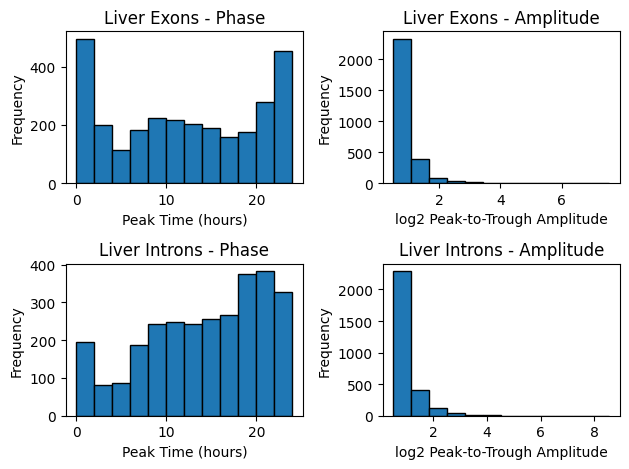

In [31]:
import matplotlib.pyplot as plt

# Exons - liver

# Phase for Liver Exons
plt.subplot(2, 2, 1)
plt.hist(results_exon_liver.loc[gene_liver_exon, 'phase'], bins=12, edgecolor='k')
plt.title("Liver Exons - Phase")
plt.xlabel("Peak Time (hours)")
plt.ylabel("Frequency")
# Amplitude for Liver Exons
plt.subplot(2, 2, 2)
plt.hist(results_exon_liver.loc[gene_liver_exon, 'amp'], bins=12, edgecolor='k')
plt.title("Liver Exons - Amplitude")
plt.xlabel("log2 Peak-to-Trough Amplitude")
plt.ylabel("Frequency")

# Introns - liver

# Phase for Liver Introns
plt.subplot(2, 2, 3)
plt.hist(results_intron_liver.loc[gene_liver_intron, 'phase'], bins=12, edgecolor='k')
plt.title("Liver Introns - Phase")
plt.xlabel("Peak Time (hours)")
plt.ylabel("Frequency")
# Amplitude for Liver Introns
plt.subplot(2, 2, 4)
plt.hist(results_intron_liver.loc[gene_liver_intron, 'amp'], bins=12, edgecolor='k')
plt.title("Liver Introns - Amplitude")
plt.xlabel("log2 Peak-to-Trough Amplitude")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Exons - muscle

# Phase for Muscle Exons
plt.subplot(2, 2, 1)
plt.hist(results_exon_muscle.loc[gene_muscle_exon, 'phase'], bins=12, edgecolor='k')
plt.title("Muscle Exons - Phase")
plt.xlabel("Peak Time (hours)")
plt.ylabel("Frequency")
# Amplitude for Muscle Exons
plt.subplot(2, 2, 2)
plt.hist(results_exon_muscle.loc[gene_muscle_exon, 'amp'], bins=12, edgecolor='k')
plt.title("Muscle Exons - Amplitude")
plt.xlabel("log2 Peak-to-Trough Amplitude")
plt.ylabel("Frequency")

# Introns - muscle

# Phase for Muscle Introns
plt.subplot(2, 2, 3)
plt.hist(results_intron_muscle.loc[gene_muscle_intron, 'phase'], bins=12, edgecolor='k')
plt.title("Muscle Introns - Phase")
plt.xlabel("Peak Time (hours)")
plt.ylabel("Frequency")
# Amplitude for Muscle Introns
plt.subplot(2, 2, 4)
plt.hist(results_intron_muscle.loc[gene_muscle_intron, 'amp'], bins=12, edgecolor='k')
plt.title("Muscle Introns - Amplitude")
plt.xlabel("log2 Peak-to-Trough Amplitude")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### Answer (Experiment 2- question 1-3)

The phase graph of the liver exons shows that ZT22-24 and ZT0-2 have the highest frequencies, indicating that transcription occurs actively at night, accumulating RNA, and translation begins in the morning. Similarly, the phase graph of the liver introns shows that the dark period (ZT12-24) has higher values ​​than the light period (ZT0-12). This also suggests that transcription occurs during the dark period, accumulating RNA, which is consistent with the exon graph. The rhythmic pattern of the liver is consistent with the physiological role of the liver during the dark period, such as glycogen storage and detoxification. This observation suggests that stable expression patterns are more dominant than strong rhythmic patterns to support basic metabolic processes and important functions of the liver.

The phase graph of the muscle shows that expression increases gradually around ZT10 and then decreases, peaking at ZT22-24. The intron phase results show a similar pattern, suggesting that gene expression increases during the day to support energy expenditure and metabolic activity, while gene expression at night is necessary for tissue repair. As with the liver, both the intron and exon amplitude graphs are concentrated in 1-2, but with much lower frequencies than the liver.

When comparing liver and muscle, the liver appears to have a temporally separated regulatory pattern with distinct transcription and translation, which seems to prepare for metabolic activity during the day. In contrast, muscle regulates gene expression to its activity-rest cycle, expressing it during the day for energy consumption and at night for tissue repair. Both tissues have strong rhythmic genes in the amplitude graph, and the liver has much higher frequencies than the muscle, indicating that it has more rhythmic genes. Since muscle is regulated by external stimuli (exercise), it is thought to have fewer rhythmic genes than the liver, which maintains body homeostasis.


### Question 2

1. Related to Exercise 1, study the relationship between the peak times (i.e., phase) of pre-mRNA and mRNA for genes that exhibit rhythmic behavior at both the pre-mRNA and mRNA levels in each tissue independently. Use appropriate cutoffs in your analysis to select a subset of genes that are rhythmic at both the pre-mRNA and mRNA levels. Aim to include several hundred genes for a robust analysis.  
   **Hint:** Show a scatter plot of mRNA vs. pre-mRNA peak times. Explain your findings.

2. Show representative profiles of genes with short or long delays between the pre-mRNA and mRNA peak times.

3. From the delay between the pre-mRNA and mRNA ($\delta t$ [hr]), infer the mRNA half-life ($\tau$ [hr]) using the formula derived in the course:  


   $$\tan\left(\frac{2\pi \cdot \delta t}{24}\right) = \frac{24}{2\pi}  \frac{ \tau}{\ln(2)}$$
 

   Plot the histogram of the inferred mRNA half-lives for each tissue. Explain your findings.

4. For the selected genes that are common between muscle and liver, compare their mRNA half-lives. Show representative profiles of genes with tissue-specific half-lives. 

5. **(Bonus):** What can you infer about the splicing rate?  





#### Plot pre-mRNA, mRNA delay

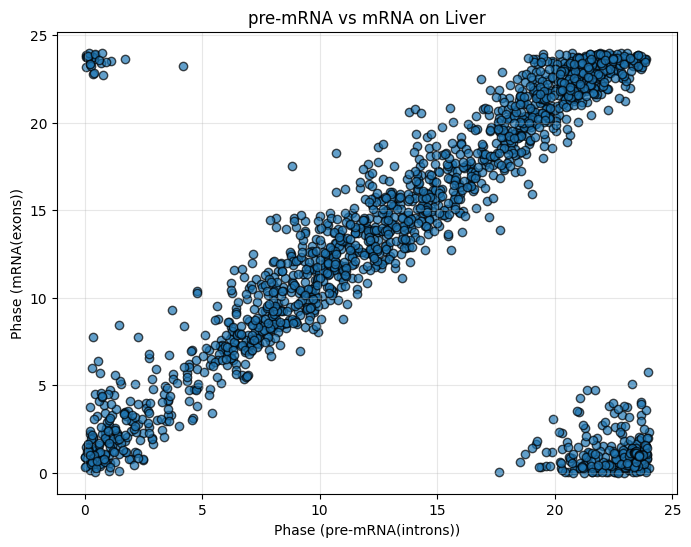

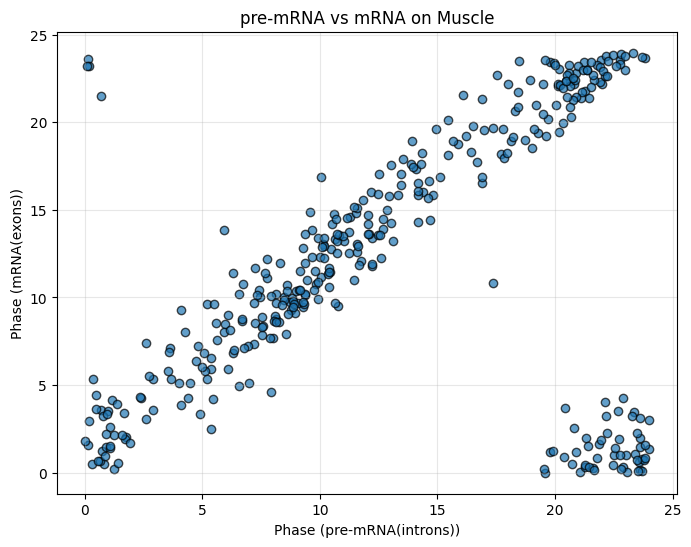

In [37]:

#plot phase intron vs phase exon for gene_liver

# Extraction genes both in introns and exons
gene_liver = results_intron_liver.index[gene_liver_intron].intersection(results_exon_liver.index[gene_liver_exon])

# Scatter plot - Liver 
plt.figure(figsize=(8, 6))
plt.scatter(results_intron_liver.loc[gene_liver, 'phase'],
            results_exon_liver.loc[gene_liver, 'phase'],
            alpha=0.7, edgecolor='k')
plt.xlabel('Phase (pre-mRNA(introns))')
plt.ylabel('Phase (mRNA(exons))')
plt.title('pre-mRNA vs mRNA on Liver')
plt.grid(alpha=0.3)
plt.show()


#plot phase intron vs phase exon for gene_muscle

# Extraction genes both in introns and exons
gene_muscle = results_intron_muscle.index[gene_muscle_intron].intersection(results_exon_muscle.index[gene_muscle_exon])
# Scatter plot - Muscle 
plt.figure(figsize=(8, 6))
plt.scatter(results_intron_muscle.loc[gene_muscle, 'phase'],
            results_exon_muscle.loc[gene_muscle, 'phase'],
            alpha=0.7, edgecolor='k')
plt.xlabel('Phase (pre-mRNA(introns))')
plt.ylabel('Phase (mRNA(exons))')
plt.title('pre-mRNA vs mRNA on Muscle')
plt.grid(alpha=0.3)
plt.show()

### Answer for experiment 2 - question 2-1
The analysis results show that in both liver and muscle, the majority of genes are clustered around the 45 degree line in the center. This means that the rhythms of the transcription level (pre-mRNA) and the translation readiness level (mRNA) are well synchronized in time. However, in the liver, as analyzed in Problem 1, the pre-mRNA (intron) shows a more distinct clustering at ZT20-24. This means that transcription is concentrated during the dark time period, and the clustering of mRNA at ZT0-2 also shows that translation begins during the light time period, as in Problem 1. In the case of muscle, the number of rhythmic genes is smaller than that of the liver, and as in Problem 1, transcription and translation increase as they go from ZT10-12 to 22-24.


### Plot representative genes with short or long-delay

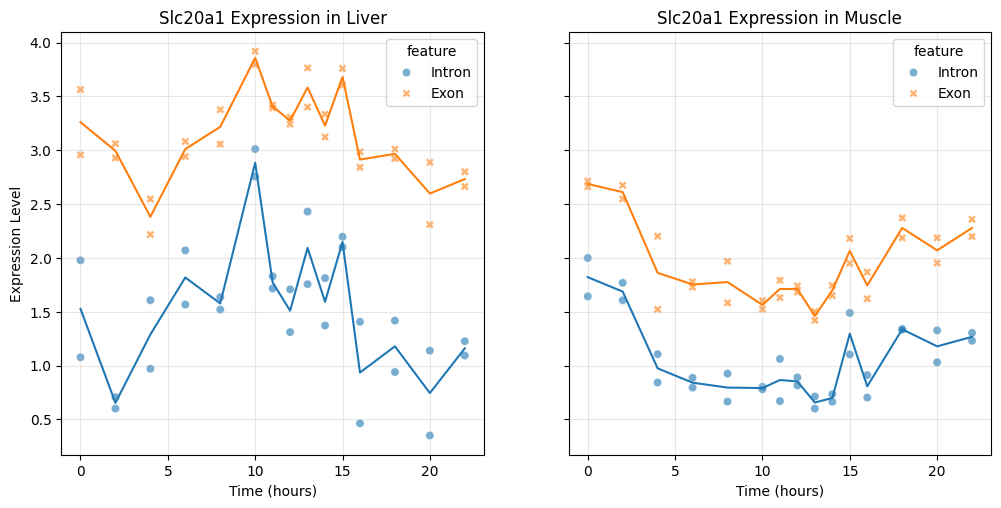

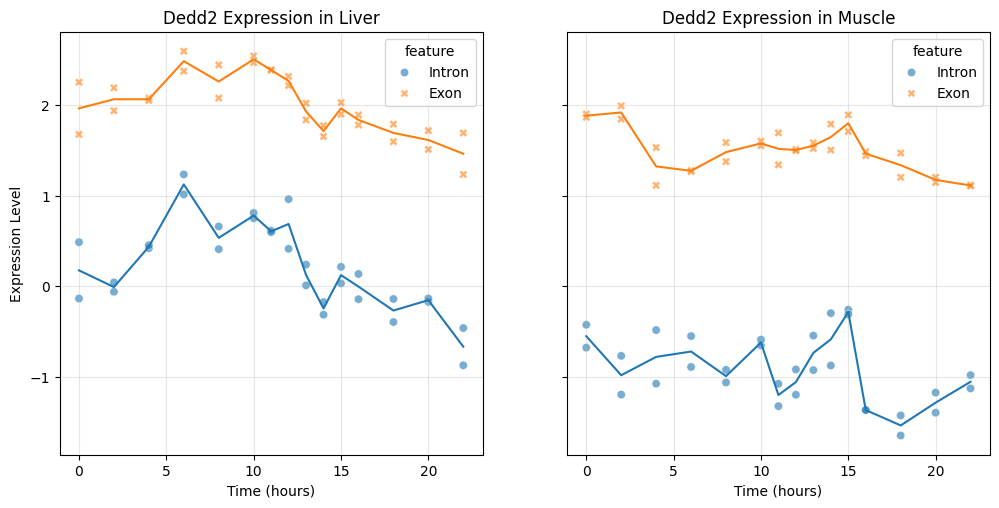

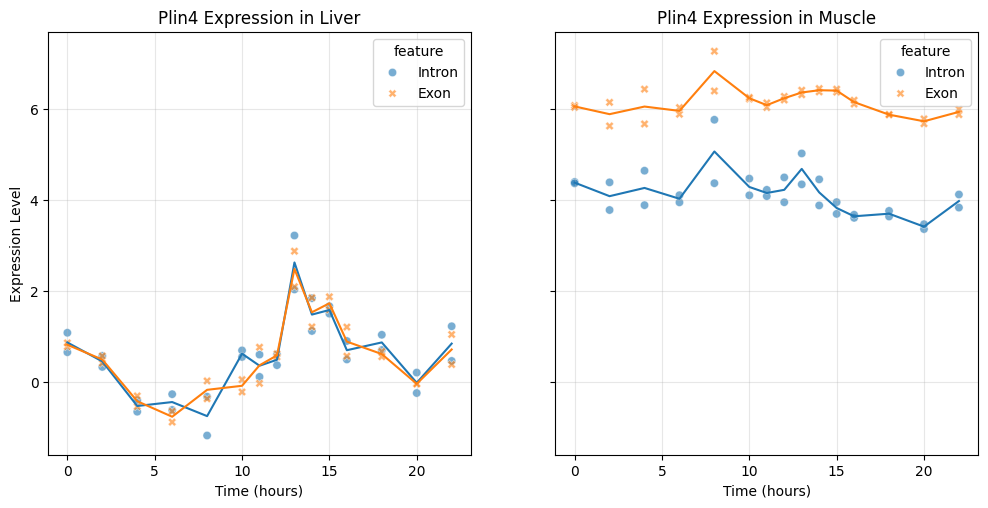

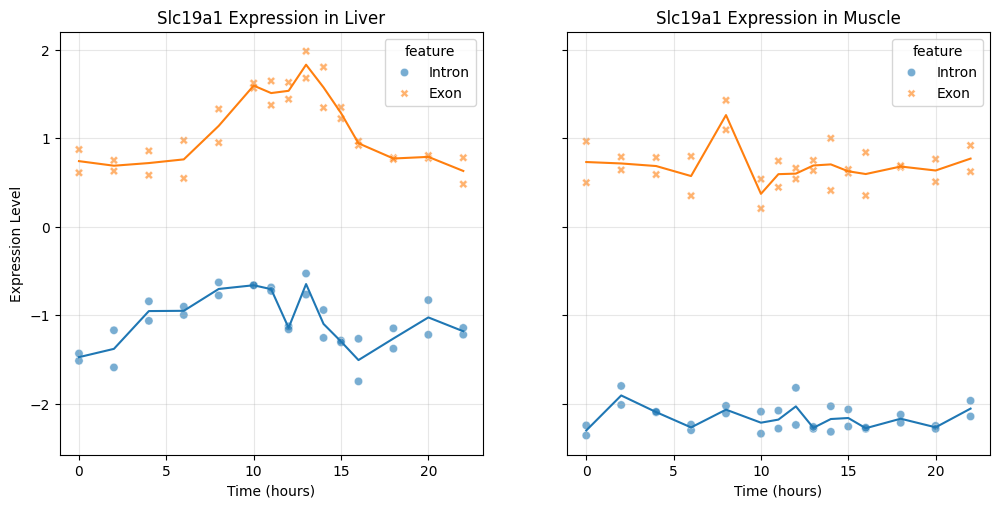

In [40]:
#compute the delay between intron and exon for liver and muscle
#restrict to genes with phase difference < 6 hours and with exon later than intron

# Delay for liver
liver_delay = results_exon_liver.loc[gene_liver, 'phase'] - results_intron_liver.loc[gene_liver, 'phase']
liver_delay = liver_delay[(liver_delay > 0) & (liver_delay < 6)]

# Delay for muscle
muscle_delay = results_exon_muscle.loc[gene_muscle, 'phase'] - results_intron_muscle.loc[gene_muscle, 'phase']
muscle_delay = muscle_delay[(muscle_delay > 0) & (muscle_delay < 6)]

#find gene with shortest delay in muscle and liver, plot representative gene expression
shortest_delay_muscle_gene = muscle_delay.idxmin()  
plot_gene_expression(dat_melted, shortest_delay_muscle_gene)

shortest_delay_liver_gene = liver_delay.idxmin() 
plot_gene_expression(dat_melted, shortest_delay_liver_gene)

#find gene with delay between 3 and 4 hours in muscle and liver
muscle_delay_3_4 = muscle_delay[(muscle_delay >= 3) & (muscle_delay < 4)]
shortest_muscle_gene_3_4 = muscle_delay_3_4.idxmin()
plot_gene_expression(dat_melted, shortest_muscle_gene_3_4)

liver_delay_3_4 = liver_delay[(liver_delay >= 3) & (liver_delay < 4)]
shortest_liver_gene_3_4 = liver_delay_3_4.idxmin()
plot_gene_expression(dat_melted, shortest_liver_gene_3_4)



### Compute half-life from the delay between intron and exon


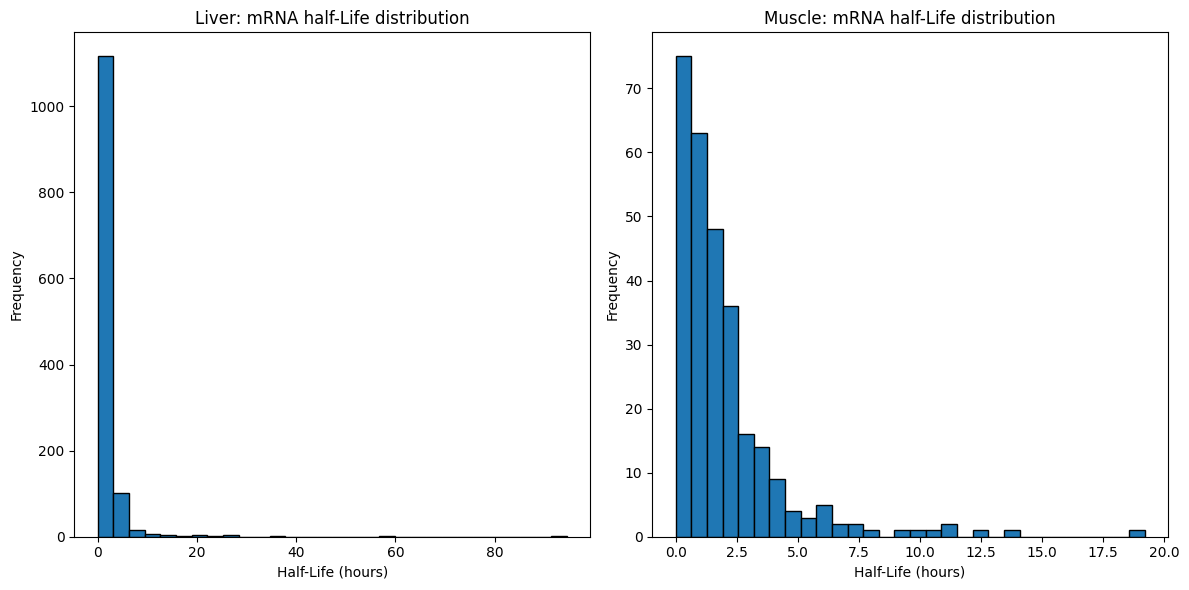

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate half-life for liver mRNA
liver_tau = (np.log(2) / (2 * np.pi)) * np.tan((2 * np.pi * liver_delay) / 24) * 24
liver_tau = liver_tau[liver_tau > 0]  

# Calculate half-life for muscle mRNA
muscle_tau = (np.log(2) / (2 * np.pi)) * np.tan((2 * np.pi * muscle_delay) / 24) * 24
muscle_tau = muscle_tau[muscle_tau > 0]  

# Plot histograms
plt.figure(figsize=(12, 6))

# Liver
plt.subplot(1, 2, 1)
plt.hist(liver_tau, bins=30, edgecolor='k')
plt.title('Liver: mRNA half-Life distribution')
plt.xlabel('Half-Life (hours)')
plt.ylabel('Frequency')

# Muscle
plt.subplot(1, 2, 2)
plt.hist(muscle_tau, bins=30, edgecolor='k')
plt.title('Muscle: mRNA half-Life distribution')
plt.xlabel('Half-Life (hours)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Answer for experiment 2 - question 2-3

00000

### Compare half-lives between muscle and liver

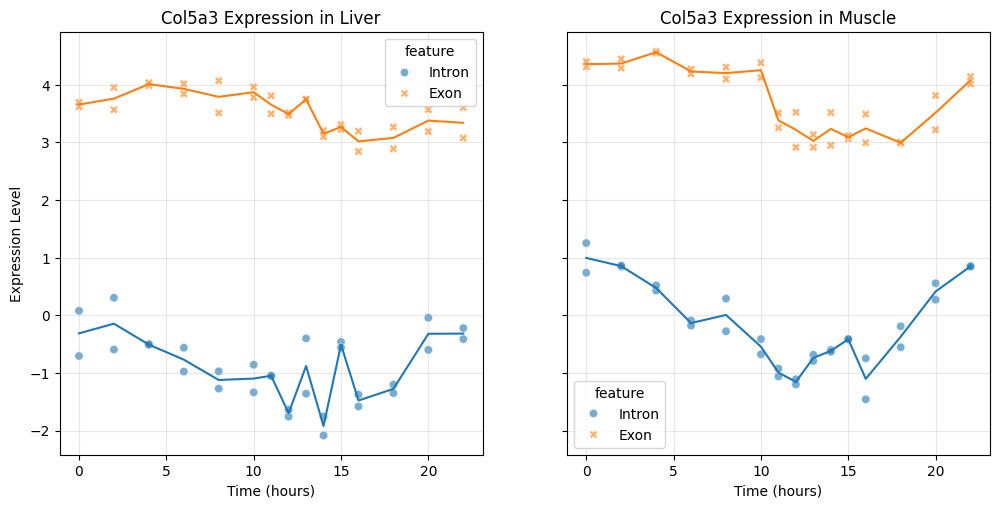

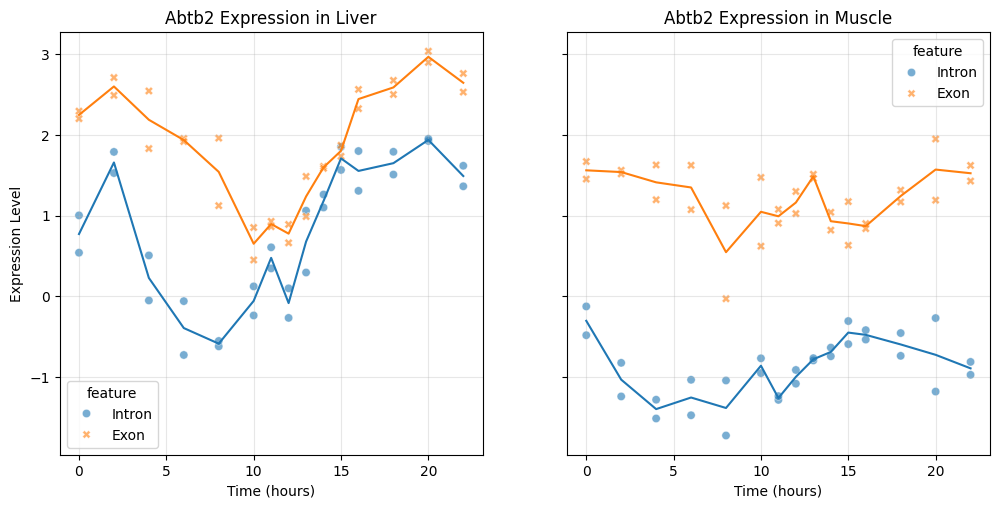

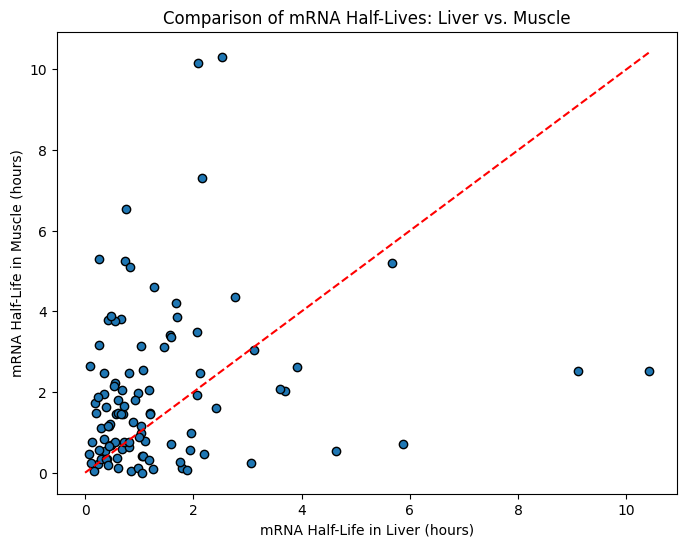

In [46]:
# Extract common genes 
common_genes = liver_tau.index.intersection(muscle_tau.index)

# Common genes' half-life 
common_liver_tau = liver_tau.loc[common_genes]
common_muscle_tau = muscle_tau.loc[common_genes]

# Representative profiles of genes with Liver-specific half-lives
liver_specific_gene = (common_liver_tau - common_muscle_tau).idxmax()  
plot_gene_expression(dat_melted, liver_specific_gene)

# Representative profiles of genes with Muscle-specific half-lives
muscle_specific_gene = (common_muscle_tau - common_liver_tau).idxmax()  
plot_gene_expression(dat_melted, muscle_specific_gene)

# Scatter plot comparing mRNA half-lives
plt.figure(figsize=(8, 6))
plt.scatter(common_liver_tau, common_muscle_tau, edgecolor='k')
plt.plot([0, max(common_liver_tau.max(), common_muscle_tau.max())],
         [0, max(common_liver_tau.max(), common_muscle_tau.max())], 'r--')
plt.xlabel('mRNA Half-Life in Liver (hours)')
plt.ylabel('mRNA Half-Life in Muscle (hours)')
plt.title('Comparison of mRNA Half-Lives: Liver vs. Muscle')
plt.show()


### Plot representative genes with tissue-specific half-life

In [ ]:
#...
#...

#plot_gene_expression(dat_melted, 'GeneName')
 